In [1]:
import json
import requests
import json
import base64
import os
import time
import random
from PIL import Image
from io import BytesIO
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
from requests_aws4auth import AWS4Auth
from requests.auth import HTTPBasicAuth
from botocore.exceptions import ClientError
from os import listdir, walk
import boto3
from requests.exceptions import RequestException


In [ ]:
# 这里需要根据AWS环境进行修改
local_image_path = './images/' # 本地存放图片的目录
os_endpoint = "search-opensearchdomai-buu1doweasvh-f3zxit7lojvvgfiyhhzmnfrgwe.us-east-1.es.amazonaws.com" # opensearch endpoint
api_url = "https://gp3twqx1id.execute-api.us-east-1.amazonaws.com/prod" # 部署模版得到的 api gateway url, 不要有最后的 /
bucket_name = 'imagebucket-983760593521-us-east-1' # 部署模版中创建的 S3 桶名
s3_client = boto3.client('s3')
region = 'us-east-1'

In [3]:
def image_to_base64(image_path):
    with Image.open(image_path) as img:
        # 如果图片有透明通道，先转换为 RGB
        if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
            # 创建白色背景
            background = Image.new('RGB', img.size, (255, 255, 255))
            # 将原图粘贴到白色背景上
            if img.mode == 'RGBA':
                background.paste(img, mask=img.split()[3])  # 使用alpha通道作为蒙版
            else:
                background.paste(img)
            img = background
        elif img.mode != 'RGB':
            img = img.convert('RGB')
            
        # 创建一个字节流对象
        buffered = BytesIO()
        # 将图片保存为 JPEG 格式
        img.save(buffered, format='JPEG', quality=95)
        # 获取字节数据并进行 Base64 编码
        img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
        return img_base64

In [4]:
# display image with limit
def display_with_limit(image_path, max_size=(300, 300)):
    # 打开图片
    with Image.open(image_path) as img:
        # 使用 thumbnail 方法保持图片比例，缩放到不超过指定大小
        img.thumbnail(max_size)
        # 显示图片
        display(img)

In [10]:
# opensearch search query
def opensearch_search_query(query_image_path, query_text, aws4auth):
    # construct payload
    payload = {}
    if query_image_path == '':
        payload["query_image"] = None
    else:
        payload["query_image"] = image_to_base64(query_image_path)
        
    payload["query_text"] = query_text

    # send request
    response = requests.post(api_url + "/images/search", 
        json=payload,
        headers={"Content-Type": "application/json"},
        auth=aws4auth
    )
    # print(response.json())
    return response.json()
    

In [6]:
# 修改后的 display_search_result 函数
def display_search_result(response):
    
    # 确保 tmp 目录存在
    if not os.path.exists('tmp'):
        os.makedirs('tmp')
        
    for result in response['data']['results']:
        # 获取图片 URL
        image_url = result['image_path']
        
        # 修复 CloudFront URL 格式问题
        if 'cloudfront.net' in image_url:
            # 检查并修复 URL 中缺少的斜杠
            if 'cloudfront.netimages' in image_url:
                image_url = image_url.replace('cloudfront.netimages', 'cloudfront.net/images')
            
        # 添加 HTTPS 协议
        if not image_url.startswith('http'):
            image_url = 'https://' + image_url
            
        try:
            print(f"正在下载: {image_url}")
            img_response = requests.get(image_url)
            if img_response.status_code == 200:
                file_name = image_url.split('/')[-1]
                file_path = f'tmp/{file_name}'
                with open(file_path, 'wb') as f:
                    f.write(img_response.content)
                display_with_limit(file_path)
            else:
                print(f"无法下载图片: {image_url}, 状态码: {img_response.status_code}")
        except Exception as e:
            print(f"下载图片时出错: {image_url}")
            print(f"错误: {str(e)}")


In [7]:
files_list = []

for (root, dirs, files) in walk(local_image_path):
    if ".DS_Store" in files:
        files.remove(".DS_Store")
    files_list.extend([ root + "/" + x for x in files ])
    
print(files_list)

['./images//image(17).png', './images//image(16).png', './images//image(14).png', './images//image(11).png', './images//image(9).png', './images//image(13).png', './images//image(10).png', './images//image(12).png', './images//image(15).png']


In [22]:
session = boto3.Session()
credentials = session.get_credentials()
aws4auth = AWS4Auth(
    credentials.access_key,
    credentials.secret_key,
    region,
    'execute-api',
    session_token=credentials.token
)

# Add retry parameters
max_retries = 10
retry_delay_base = 2  # Base delay in seconds
success_count = 0
failure_count = 0
failed_files = []
count = 0

for file in files_list:
    count += 1
    # Construct payload
    payload = {}
    payload["image"] = image_to_base64(file)
    # Add description to bypass automatic generation
    
    # Retry logic
    retries = 0
    success = False
    
    while retries <= max_retries and not success:
        try:
            # Send request
            response = requests.post(
                api_url + "/images", 
                json=payload,
                headers={"Content-Type": "application/json"},
                auth=aws4auth,
                timeout=30  # Add timeout
            )
            
            response_data = response.json()
            # print(f"Response for {file}: {response_data}")
            
            # Check if successful (only count 200 responses as success)
            if response.status_code == 200 and response_data.get('code') == 200:
                print(f"Successfully uploaded {file} ({count}/{len(files_list)})")
                success = True
                success_count += 1
            else:
                # If throttling error, retry with backoff
                if "ThrottlingException" in str(response_data):
                    # Exponential backoff with jitter
                    delay = (retry_delay_base ** retries) + random.uniform(0, 1)
                    print(f"Throttling detected, retrying in {delay:.2f} seconds...")
                    time.sleep(delay)
                    retries += 1
                else:
                    print(f"Error uploading {file}: {response_data}")
                    failed_files.append(file)
                    failure_count += 1
                    break
                    
        except RequestException as e:
            print(f"Request error for {file}: {str(e)}")
            # Exponential backoff with jitter
            delay = (retry_delay_base ** retries) + random.uniform(0, 1)
            print(f"Retrying in {delay:.2f} seconds...")
            time.sleep(delay)
            retries += 1
            
        except Exception as e:
            print(f"Unexpected error for {file}: {str(e)}")
            failed_files.append(file)
            failure_count += 1
            break
    
    # If all retries failed
    if not success and retries > max_retries:
        failed_files.append(file)
        failure_count += 1

# Print summary
print(f"\nUpload Summary:")
print(f"Total files: {len(files_list)}")
print(f"Successfully uploaded: {success_count}")
print(f"Failed: {failure_count}")

if failed_files:
    print("\nFailed files:")
    for file in failed_files:
        print(f"- {file}")



Successfully uploaded ./images//image(17).png (1/9)
Successfully uploaded ./images//image(16).png (2/9)
Throttling detected, retrying in 1.18 seconds...
Successfully uploaded ./images//image(14).png (3/9)
Throttling detected, retrying in 1.54 seconds...
Throttling detected, retrying in 2.12 seconds...
Successfully uploaded ./images//image(11).png (4/9)
Throttling detected, retrying in 1.35 seconds...
Throttling detected, retrying in 2.24 seconds...
Successfully uploaded ./images//image(9).png (5/9)
Throttling detected, retrying in 1.31 seconds...
Throttling detected, retrying in 2.55 seconds...
Throttling detected, retrying in 4.13 seconds...
Successfully uploaded ./images//image(13).png (6/9)
Throttling detected, retrying in 1.02 seconds...
Throttling detected, retrying in 2.75 seconds...
Successfully uploaded ./images//image(10).png (7/9)
Throttling detected, retrying in 1.06 seconds...
Throttling detected, retrying in 2.57 seconds...
Successfully uploaded ./images//image(12).png (8/

In [31]:
session = boto3.Session()
credentials = session.get_credentials()
aws4auth = AWS4Auth(
    credentials.access_key,
    credentials.secret_key,
    region,
    'execute-api',
    session_token=credentials.token
)

# ./img_for_search/search calculus.png  the graph below shows the equation \\y(x) = \\frac{ax+b}{c-x}, the equation of the asymptotes are x=3 and y=-2, Write down the value of c. Calculate the value of a. 

response = opensearch_search_query('', "if f(x) is the floor function", aws4auth)
print(json.dumps(response, indent=2))

{
  "code": 200,
  "message": "Search completed successfully",
  "data": {
    "results": [
      {
        "id": "7gZVCJgBmLK0u48BfeQA",
        "score": 0.60807383,
        "description": "<result>\n\n# Calculus Question Analysis\n\n## Question Text\n\"If \\( f(x) \\) is the floor function, which answer shows the graph of \\( g(x) = f(x) + 117 \\)?\"\n\n## Mathematical Concepts\n- Floor function\n- Function transformation\n\n## Diagram Analysis\nThe image presents four different graphs, each representing a function. The floor function, denoted as \\( f(x) \\), outputs the greatest integer less than or equal to \\( x \\). The graphs are plotted on a standard Cartesian coordinate system with both horizontal (x-axis) and vertical (y-axis) axes. Each graph shows a step-like pattern characteristic of the floor function. The transformation \\( g(x) = f(x) + 117 \\) indicates a vertical shift of the floor function by 117 units upwards.\n\n## Question Objective\nThe student needs to identify

正在下载: https://dkfy8iaoan5yn.cloudfront.net/images/b0cc57a0-b0ef-4bc1-971b-8bda0e191568


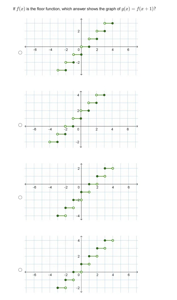

正在下载: https://dkfy8iaoan5yn.cloudfront.net/images/f95b028e-201d-40d2-86c0-fcaf38793f02


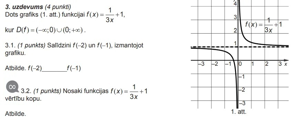

正在下载: https://dkfy8iaoan5yn.cloudfront.net/images/e0135b0f-9474-4453-badd-126ab0db6599


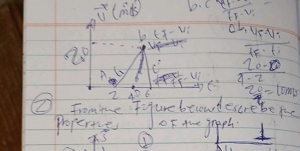

正在下载: https://dkfy8iaoan5yn.cloudfront.net/images/b78839de-fac9-467c-b2bb-e6dccbad3a38


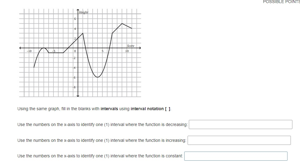

正在下载: https://dkfy8iaoan5yn.cloudfront.net/images/fc15a17f-5138-4703-b5cc-cbb8b6e1b9d2


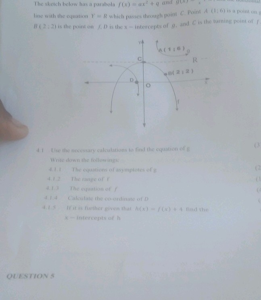

正在下载: https://dkfy8iaoan5yn.cloudfront.net/images/f57d315b-6cdc-4249-80be-4e29699cde8a


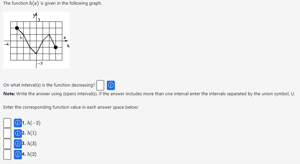

正在下载: https://dkfy8iaoan5yn.cloudfront.net/images/7375d443-7699-4172-937d-cc8ffce51510


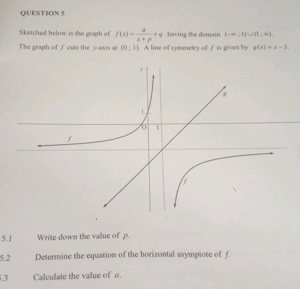

正在下载: https://dkfy8iaoan5yn.cloudfront.net/images/b14d15cc-d9c2-4f02-bf42-e117693b4d61


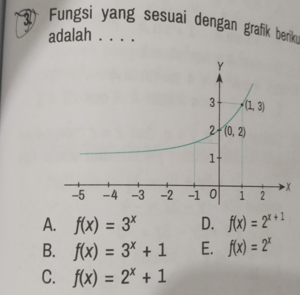

正在下载: https://dkfy8iaoan5yn.cloudfront.net/images/e491ecf2-1387-4b38-ab3c-efce15b5367a


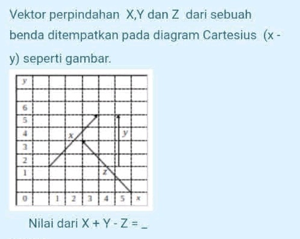

In [32]:
display_search_result(response)

In [21]:
def list_all_images():
    # Use text search with a very generic query to get all images
    payload = {
        "query_text": "*",  # Generic query to match everything
        "query_image": None,
        "k": 1000  # Set a high limit to get all images
    }
    
    response = requests.post(
        f"{api_url}/images/search",
        json=payload,
        headers={"Content-Type": "application/json"}
        
    )
    
    if response.status_code == 200:
        results = response.json()
        if 'data' in results and 'results' in results['data']:
            return results['data']['results']
    
    print(f"Error listing images: {response.text}")
    return []

def delete_image(image_id):
    response = requests.delete(
        f"{api_url}/images/{image_id}",
        headers={"Content-Type": "application/json"}
    )
    
    if response.status_code == 200:
        print(f"Successfully deleted image {image_id}")
        return True
    else:
        print(f"Failed to delete image {image_id}: {response.text}")
        return False

# List all images
all_images = list_all_images()
print(f"Found {len(all_images)} images")

# Delete all images
for image in all_images:
    image_id = image['id']
    print(f"Deleting image {image_id}...")
    success = delete_image(image_id)
    
    # Add a small delay to avoid overwhelming the API
    time.sleep(0.5)

print("Deletion process completed")


Found 18 images
Deleting image 6AZSCJgBmLK0u48BzuT2...
Successfully deleted image 6AZSCJgBmLK0u48BzuT2
Deleting image 4wZQCJgBmLK0u48BgeQQ...
Successfully deleted image 4wZQCJgBmLK0u48BgeQQ
Deleting image 3QaoB5gBmLK0u48BO-TG...
Successfully deleted image 3QaoB5gBmLK0u48BO-TG
Deleting image 3gaoB5gBmLK0u48BnOSN...
Successfully deleted image 3gaoB5gBmLK0u48BnOSN
Deleting image 4AapB5gBmLK0u48BleSP...
Successfully deleted image 4AapB5gBmLK0u48BleSP
Deleting image 5gZRCJgBmLK0u48B0eRc...
Successfully deleted image 5gZRCJgBmLK0u48B0eRc
Deleting image 5AZQCJgBmLK0u48B8uR-...
Successfully deleted image 5AZQCJgBmLK0u48B8uR-
Deleting image 5wZSCJgBmLK0u48BReQd...
Successfully deleted image 5wZSCJgBmLK0u48BReQd
Deleting image 2wanB5gBmLK0u48BT-Q7...
Successfully deleted image 2wanB5gBmLK0u48BT-Q7
Deleting image 6QZTCJgBmLK0u48BKeSP...
Successfully deleted image 6QZTCJgBmLK0u48BKeSP
Deleting image 3AanB5gBmLK0u48BteT3...
Successfully deleted image 3AanB5gBmLK0u48BteT3
Deleting image 5QZRCJgBmLK0